**making the script to run everything for optical detectors assignmet**

In [54]:
%%writefile optical_detectors.py

"""
optical_detectors.py

Description:
    This script will produce an HR diagram using images from 2 filters as inputs. 

Usage:
    Run the script from command line and optionally pass the following arguments:
    1. file path to teh F336W images
    2. file path to the F555W images

Output:
    1. HR diagram of the target made with the inputted images
    2. historgrams of the FHWM of detected sources for each filter
    3. printed information: number of peaks dtected, number of peaks counted as sources, number of peaks thrown out
"""
import argparse
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt

import ccd_utils as cutils
from scipy.optimize import curve_fit

from glob import glob 
import scipy.ndimage as ndi

import pandas as pd
from IPython.display import display

#functions listed alphabetically because there are lots:

def catalog_creator(data336, data555, coords):
    """
    This function will create a catalog of found stars including their coordinates, 
    and for each filter: the star flux, aparent magnitude, and absolute magnitude

    Inputs: flux data array, array of passed (likely stars) coordinates
    Output: pandas dataframe:
        ID: ID of star
        x_center, y_center: center coordinates of star 
        F### flux: next flux within aperture, with background flux subtracted, for either filter
        F### Aparent Mag: apparent magnitude for either filter
        F### Absolute Mag: absolute magnitude for either filter
    """
    fluxes336 = []
    for coord in coords:
        fluxes336.append(find_flux(data336, coord))\
        
    fluxes555 = []
    for coord in coords:
        fluxes555.append(find_flux(data555, coord))
    
    
    aparent_mags336 = []
    for flux in fluxes336:
        aparent_mags336.append(flux_to_apparent_mag(flux, -21.1)) #zp set to -21.1 for this data

    absolute_mags336 = []
    for mag in aparent_mags336:
        absolute_mags336.append(m_to_M(mag, 16400)) #distance = 16400 according to the hst workbook 3

    aparent_mags555 = []
    for flux in fluxes555:
        aparent_mags555.append(flux_to_apparent_mag(flux, -21.1)) #zp set to -21.1 for this data

    absolute_mags555 = []
    for mag in aparent_mags555:
        absolute_mags555.append(m_to_M(mag, 16400)) #distance = 16400 according to the hst workbook 3

    catalog_data = {
        'ID' : [i for i in range(len(coords))],
        'x center':  [coord[0] for coord in coords],
        'y center':  [coord[1] for coord in coords],
        'aperture radius': [4 for i in range(len(coords))],
        'F336 Flux': fluxes336,
        'F555 Flux': fluxes555,
        'F336 Aparent Mag': aparent_mags336,
        'F555 Aparent Mag': aparent_mags555,
        'F336 Absolute Mag': absolute_mags336,
        'F555 Absolute Mag': absolute_mags555,
    }

    return pd.DataFrame(catalog_data)

def check_ellipticity(sigma_x, sigma_y, etol=0.5):
    """
    Use Gaussian parameters to calculate the flattening or ellipticity (credt: assignment guidelines)
    """
    f = 1 - (min(sigma_x, sigma_y) / max(sigma_x, sigma_y))

    ellipse_okay = f <= etol

    if ellipse_okay:
        return True 
    else: return False

def circular_aperture(data, center, radius):
    """
    Extract a circular cutout from the input data

    Parameters:
    -----------
    data : `np.ndarray`
        the input data
    center : list or tuple
        the center of the circle to extract, in y-x order
    radius : int or float
        the radius of the circle in pixels

    Returns:
    -----------
    cutout : `np.ndarray`
        a square cutout of the data
    mask : `np.ndarray`
        the circular mask used for the operation
    """

    box_size = int(np.ceil(2 * radius))
    cutout = cutils.square_aperture(data, center = center, box_size = box_size)

    ys, xs = np.indices(cutout.shape) #creates grid of the cutout area as indices

    xc = cutout.shape[1] // 2 #approximate integer x center of cutout
    yc = cutout.shape[0] // 2

    #handle bits for the mask:
    #get the pixel start position for the mask:
    y0 = yc - (box_size // 2)
    x0 = xc - (box_size // 2)

    #now get the index coords
    x_coords = xs + x0
    y_coords = ys + y0

    #get the distance from center to calc the mask
    distance = np.sqrt((x_coords - xc)**2 + (y_coords - yc)**2)

    #anything where distance > radius, will be False, True is for all values within circle radius 

    mask = distance <= radius

    return cutout, mask

def convert_to_flux(filename):
    """
    Function that extracts the header data from a fits file and converts the units for each pixel from counts to flux
    Then it returns the flux data and header data from the file

    this function was made in class in hstworkbook3
    
    Inputs: .fits file
    Outputs: flux data, primary header, header

    """
    with fits.open(filename) as hdul:
        header = hdul[1].header
        primary = hdul[0].header
        data = hdul[1].data
        
        
        photflam = header['PHOTFLAM']
        exptime = primary['EXPTIME']

        if header['BUNIT'].strip() == 'COUNTS':
            flux_data = data.copy() * photflam / exptime
        elif data['BUNIT'].strip() == 'COUNTS/S':
            flux_data = data.copy() * photflam

        return flux_data, header, primary

def fit_gauss2d(data, p0 = None):
    """
    Function to fit a 2d gaussian
    
    Inputs: flux data
    Outputs: popt, pcov"""
    if p0 is None: 
        a0 = data.max()
        x0 = data.shape[1] / 2
        y0 = data.shape[0] / 2
        sigx0 = 0.5
        sigy0 = 0.5
        p0 = [a0, x0, y0, sigx0, sigy0]

    y, x = np.indices(data.shape)

    popt, pcov = curve_fit(gauss_2d, (y, x), data.ravel(), p0 = p0)

    return popt, pcov

def file_parser_and_combiner(filepath):
    """
    This function takes files in a given folder, converts the data to flux data, and reads the header and primary data to a dictionary.
    Then the files are median combined to remove cosmic rays

    Inputs: path to files (string)
    Outputs: 
        1. dictionary with file data, header, and primary for a given folder of files
        2. combined image (array)
    """
    filenames = glob(filepath + '*.fits')

    returns = {
        'flux_data' : [], 
        'header' : [], 
        'primary' : []
    }

    #grabbing flux data, header, and primary header information:
    for file in filenames: 
        f, h, p = convert_to_flux(file)
        returns['flux_data'].append(f)
        returns['header'].append(h)
        returns['primary'].append(p)

    #median combining the flux data of each file:
    fluxes = returns['flux_data'].copy()
    combined = median_combine(fluxes[0], fluxes[1], fluxes[2])
    
    return returns, combined

def find_flux(flux_data, coord):
    """
    This function applies a circular aperture to find the totla flux in a set aperture around a given coordinate,
    and subtracts local background flux using an anulus around the aperture used. 

    Inputs: flux data (array), and coordinate of a source (list)
    Output: total background subtracted flux of the source at the given coordinate (float)
    """
    #flux within aperture:
    cutout, mask = circular_aperture(flux_data, center = coord, radius = 5)
    aperture_flux = cutout[mask].sum()
    
    #flux within anulus, set as a ring right outside the edge of the aperture:
    cutout_r2, mask_r2 = circular_aperture(flux_data, center = coord, radius = 7)
    cutout_r1, mask_r1 = circular_aperture(flux_data, center = coord, radius = 6)
    anulus_flux = cutout_r2[mask_r2].sum() - cutout_r1[mask_r1].sum()

    #returning background subtracted flux:
    return aperture_flux - anulus_flux

def flux_check(flux):
    """
    This function will check if an inputted flux is positive
    """
    if flux > 0:
        return True
    else: return False

def flux_to_apparent_mag(f, zp):
    """Function to convert flux values to apparent magnitude"""
    mag_data = -2.5 * np.log10(f) + zp
    return mag_data

def fwhm_2d(sigma_x, sigma_y):
    """A function for finding the FHWM of sources, so I can look for trends across the sources I detect"""
    fwhm_x = 2.3548 * sigma_x
    fwhm_y = 2.3548 * sigma_y
    return (fwhm_x + fwhm_y) / 2

def gauss_2d(coords, amp, x0, y0, sigma_x, sigma_y):
    """2d gaussian function to be used in fitting"""
    y, x = coords

    gauss = amp * np.exp(
        -(((x- x0)**2) / (2*sigma_x**2) + ((y - y0)**2 / (2 * sigma_y**2))
         ))
    return gauss.ravel() #ravel flattens the array to a 1d array


def m_to_M(data, distance):
    """
    Function to convert apparant magnitude to absolute magnitude
    Inputs: Star aparant magnitude, star distance (float)
    Outputs: absolute magnitude (float)
    """
    abs_mag_data = data - (2.5 * np.log10((distance / 10)**2))
    return abs_mag_data

def median_combine(im1, im2, im3):
    """
    Function to median combine 3 2D arrays, used for cosmic ray removal
    Inputs: 3 2D arrays
    Output: 1 array
    """
    stack = np.array([im1, im2, im3]) #create 3D stack of dta arrays
    median_combined = np.median(stack, axis=0)
    return median_combined

def peak_finder(data, nsize = 10):
    """
    Function to find local peaks, using total flux and elipticity of a 2d gaussian fit to decide if the peaks are star-like

    Inputs: data array, nsize (optional, set to 10)
    Outputs: array of coordinates of found peaks
    """

    smoothed_data = ndi.gaussian_filter(data, sigma=0.5, mode='reflect')
    local_max = ndi.maximum_filter(smoothed_data, size=nsize)
    local_max_mask = (local_max == smoothed_data)
    
    coordinates = np.argwhere(local_max_mask)
    return coordinates

def peak_checker(data, coordinates):
    """
    Function to check if found peaks are stars, allowing for a list of coordinates to be passed so that I could check the same 
    locations in both images. This origionally included the "peak_finder" function but to be able to check the same coordinate list
    in both iages, the functions were split. 

    Inputs: Flux data array, coordinates array
    Outputs: 
        1. array of passed coordinates 
        2. array of failed coordinates (origionally foud but failed checks)
        3. list of FWHM at passed coordinates

    """
    passed_coordinates = []
    failed_coordinates = []
    fwhm_list = []

    for coord in coordinates:
        flux = find_flux(data, coord)

        if flux > 0:
            try:
                cutout, mask = circular_aperture(data, center = coord.T, radius = 4)
                popt, pcov = fit_gauss2d(cutout)

                if check_ellipticity(popt[3], popt[4], etol=0.5):
                    passed_coordinates.append(coord)
                    fwhm_list.append(fwhm_2d(popt[3], popt[4]))
                    
                else: 
                    failed_coordinates.append(coord)
                    
            except:
                failed_coordinates.append(coord)
                continue
                
        else: failed_coordinates.append(coord)
    
    return np.array(passed_coordinates), np.array(failed_coordinates), fwhm_list


#that is the end of the non-main functions!

def main(F336W_path, F555W_path):
    if (F336W_path is None) or (F555W_path is None): 
        F336_path = "data/F336W/"
        F555_path = "data/F555W/"

    #first: median combine the 3 files from each path to remove cosmic rays:

    F336W_dict, combined_336 = file_parser_and_combiner(F336W_path)
    F555W_dict, combined_555 = file_parser_and_combiner(F555W_path)

    #then find and check peaks against star critera, this method ensures the coordinates for foud stars are teh same for each filter image:
    coords_336 = peak_finder(combined_336)
    passed_336, failed_336, fwhm_336 = peak_checker(combined_336, coords_336)
    passed_555, failed_555, fwhm_555 = peak_checker(combined_555, passed_336)
    
    #creating a catalog:
    catalog = catalog_creator(combined_336, combined_555, passed_555)
    catalog.to_csv('star_catalog.csv', index=False)
    
    print(catalog)
    
    #plotting the results:
    
    plt.close("all")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.set_title("HR Diagram using Aparent Magnitude")
    ax1.set_ylabel("M336")
    ax1.set_xlabel("M(336 - 555)")
    ax1.scatter((catalog["F336 Aparent Mag"] - catalog["F555 Aparent Mag"]), catalog["F336 Aparent Mag"], s = 1, color = 'black')
    ax1.invert_yaxis()

    ax2.set_title("HR Diagram using Absolute Magnitude")
    ax2.set_ylabel("M336")
    ax2.set_xlabel("M(336 - 555)")
    ax2.scatter((catalog["F336 Absolute Mag"] - catalog["F555 Absolute Mag"]), catalog["F336 Absolute Mag"], s = 1, color = 'black')
    ax2.invert_yaxis()

    plt.show()

    #printing out some results of the star finding: 
    print("Information about the star finding and fitting process: \n")
    print(f"In the combined F336W image: {len(passed_336)} peaks were classified as good sources and {len(failed_336)} were removed.")
    print(f"In the combined F555W image: {len(passed_555)} good peaks from the F336 image were classified as good sources and {len(failed_555)} were removed.\n")

    #showing histograms of the FWHM: 
    plt.close("all")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    ax1.set_title('Histogram of source FWHMs from F336')
    ax1.set_xlabel('FWHM (pixels)')
    ax1.set_ylabel('Number of Sources')
    ax1.hist(fwhm_336, bins=100, color='skyblue', edgecolor='black')
    ax1.grid(True, alpha=0.3)

    ax2.set_title('Histogram of source FWHMs from F555')
    ax2.set_xlabel('FWHM (pixels)')
    ax2.set_ylabel('Number of Sources')
    ax2.hist(fwhm_555, bins=100, color='skyblue', edgecolor='black')
    ax2.grid(True, alpha=0.3)

    plt.show()

    
if __name__ == '__main__': 
    parser = argparse.ArgumentParser(description='''This script will print out an HR diagram and two historgram sublots of FHWM
    of peaks detected, along with text information about the peaks found''')
    parser.add_argument('F336W_path', type = str, help = "path to the folder with F336W files", nargs = '?', default = None)
    parser.add_argument('F555W_path', type = str, help = "path to the folder with F555W files", nargs = '?', default = None)
    args = parser.parse_args()

    main(args.F336W_path, args.F555W_path)

Overwriting optical_detectors.py


C:\Users\Bruce Ritter\UCD\Space_Detector\optical_detectors.py:188: OptimizeWarning: Covariance of the parameters could not be estimated
  


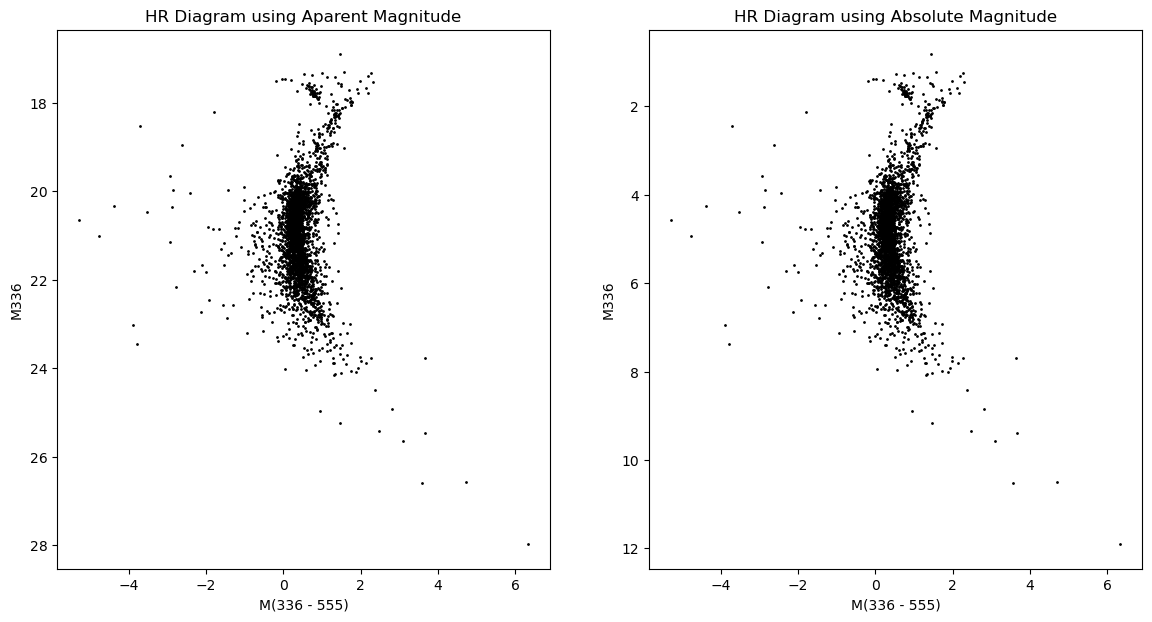

Information about the star finding and fitting process: 

In the combined F336W image: 3427 peaks were classified as good sources and 878 were removed.
In the combined F555W image: 2880 good peaks from the F336 image were classified as good sources and 547 were removed.



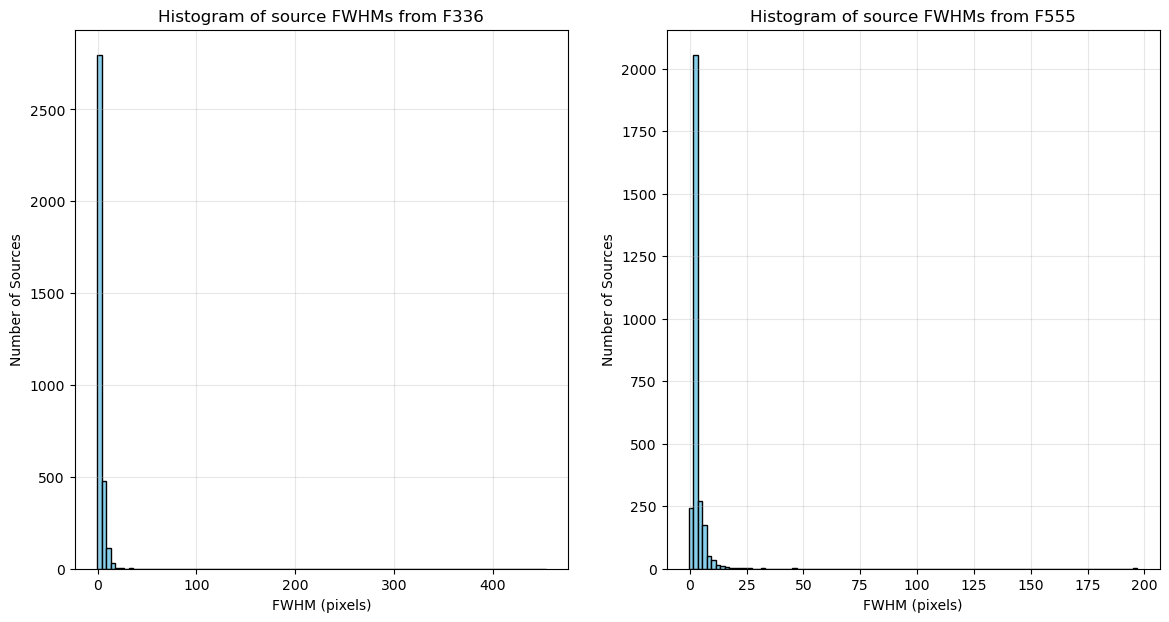

In [49]:
%run optical_detectors.py "data-files/ccd_lab_1/F336W/" "data-files/ccd_lab_1/F555W/"